In [23]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.datasets import mnist
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Set memory growth for each GPU
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"Using GPU: {gpus}")
    except RuntimeError as e:
        print(f"Error setting up GPU: {e}")
else:
    print("No GPU found. Using CPU.")

Using GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
(x_data, y_data), (x_test, y_test) = mnist.load_data()

In [4]:
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.2, random_state=42)

In [5]:
x_train = x_train.astype('float32') / 255.0
x_val = x_val.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

In [6]:
def preprocess(image, label):
    image = tf.expand_dims(image, axis=-1)
    image = tf.image.resize(image, (224, 224))
    image = tf.image.grayscale_to_rgb(image)
    return image, tf.one_hot(label, 10)

In [7]:
batch_size = 32

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = train_ds.map(preprocess).batch(batch_size).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_ds = val_ds.map(preprocess).batch(batch_size).prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_ds = test_ds.map(preprocess).batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [8]:
def create_custom_resnet(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    x = layers.Conv2D(64, (7, 7), strides=(2, 2), padding='same', activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    for _ in range(2):
        shortcut = x
        x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Conv2D(64, (3, 3), padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Add()([x, shortcut])
        x = layers.ReLU()(x)

    for _ in range(2):
        shortcut = x
        if x.shape[-1] != 128:
            shortcut = layers.Conv2D(128, (1, 1), strides=(1, 1), padding='same')(shortcut)  # Match dimensions
        x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Conv2D(128, (3, 3), padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Add()([x, shortcut])
        x = layers.ReLU()(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    return model

In [9]:
input_shape = (224, 224, 3)
num_classes = 10
model = create_custom_resnet(input_shape, num_classes)

In [10]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 64  9472        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 112, 112, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [12]:
print("Starting warmup run...")
model.fit(
    train_ds.take(1),
    epochs=1,
    validation_data=val_ds.take(1)
)
print("Warmup run completed.")

Starting warmup run...
1/1 [==============================] - 7s 7s/step - loss: 2.6863 - accuracy: 0.0938 - val_loss: 2.2979 - val_accuracy: 0.1250
Warmup run completed.


In [13]:
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

In [14]:
history = model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds,
    callbacks=[early_stopping]
)

Epoch 1/10
1500/1500 [==============================] - 273s 182ms/step - loss: 0.3708 - accuracy: 0.8860 - val_loss: 0.5007 - val_accuracy: 0.8276
Epoch 2/10
1500/1500 [==============================] - 270s 180ms/step - loss: 0.1233 - accuracy: 0.9634 - val_loss: 0.2643 - val_accuracy: 0.9137
Epoch 3/10
1500/1500 [==============================] - 270s 180ms/step - loss: 0.0936 - accuracy: 0.9716 - val_loss: 0.3473 - val_accuracy: 0.8934
Epoch 4/10
1500/1500 [==============================] - 271s 180ms/step - loss: 0.0808 - accuracy: 0.9763 - val_loss: 0.2927 - val_accuracy: 0.9147
Epoch 5/10
1500/1500 [==============================] - 270s 180ms/step - loss: 0.0691 - accuracy: 0.9791 - val_loss: 0.0628 - val_accuracy: 0.9814
Epoch 6/10
1500/1500 [==============================] - 271s 180ms/step - loss: 0.0640 - accuracy: 0.9813 - val_loss: 0.1126 - val_accuracy: 0.9701
Epoch 7/10
1500/1500 [==============================] - 272s 181ms/step - loss: 0.0551 - accuracy: 0.9838 - val_

In [15]:
train_accuracy = history.history['accuracy'][-1]
val_accuracy = history.history['val_accuracy'][-1]
print(f"Training Accuracy: {train_accuracy}")
print(f"Validation Accuracy: {val_accuracy}")

Training Accuracy: 0.9873958230018616
Validation Accuracy: 0.9817500114440918


In [26]:
y_pred = model.predict(test_ds)
y_pred_classes = tf.argmax(y_pred, axis=1).numpy()
y_true = y_test.flatten()

313/313 [==============================] - 18s 56ms/step


In [28]:
report = classification_report(y_true, y_pred_classes, target_names=[str(i) for i in range(10)])
print("\nClassification Report:\n")
print(report)


Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       980
           1       0.99      1.00      0.99      1135
           2       0.99      0.97      0.98      1032
           3       0.93      1.00      0.96      1010
           4       0.99      0.99      0.99       982
           5       0.94      0.98      0.96       892
           6       0.99      0.96      0.98       958
           7       0.99      0.98      0.99      1028
           8       1.00      0.97      0.98       974
           9       0.99      0.98      0.98      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



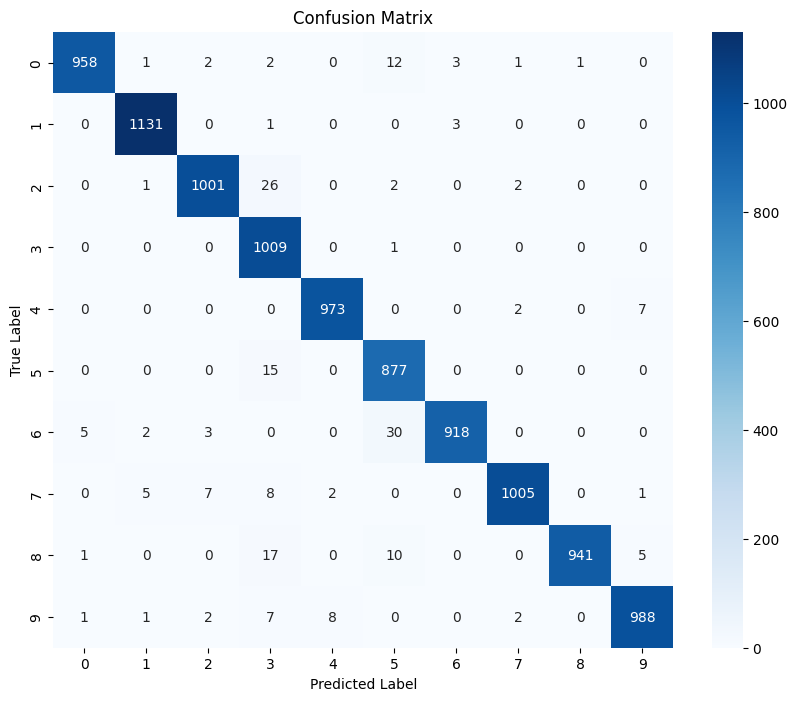

In [29]:
conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[str(i) for i in range(10)], yticklabels=[str(i) for i in range(10)])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [30]:
model.save('mnist_resnet_base.h5')